In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from tools_ryu import mytool

In [2]:
mktcap = pd.read_pickle("mktcap_pp.pickle")
price = pd.read_pickle("close_pp.pickle").replace(0,np.nan)

daily_rtn = price.pct_change(fill_method=None)

mktcap_screened = mktcap[mktcap > 1_000_000]

In [3]:
# 모멘텀 그룹을 나눌 때 사용한다
daily_rtn_pp = daily_rtn * np.sign(mktcap_screened)

In [4]:
# 언제부터 시작하는 지 찾자 (최소 100개의 코인이 필요)
cnt = daily_rtn_pp.count(1)
more100 = cnt.loc[cnt > 99] # 여기서 start date가 나온다
start = more100.index[0]
more100

date
2017-04-02     110
2017-04-03     110
2017-04-06     113
2017-04-07     114
2017-04-08     115
              ... 
2023-04-12    1487
2023-04-13    1486
2023-04-14    1492
2023-04-15    1495
2023-04-16    1501
Length: 2204, dtype: int64

In [5]:
start = "2017-04-07"

In [6]:
rtn_sample_pp = daily_rtn_pp.loc[start:]
mktcap_sample = mktcap_screened.loc[start:]
price_sample = price.loc[start:]

In [7]:
# rank를 계산해줍니다
rank = rtn_sample_pp.rank(axis=1, method="first")

# rank가 존재하는 코인의 수를 구합니다
coin_count = rank.count(axis=1)

# 그룹별로 동일한 코인 수를 포함하기 위해 각 그룹의 rank thresh를 생성해줍니다
rank_thresh = coin_count.apply(lambda x: [i for i in range(0,x, x//5)])

t1 = rank_thresh.apply(lambda x: x[1])
t2 = rank_thresh.apply(lambda x: x[2])
t3 = rank_thresh.apply(lambda x: x[3])
t4 = rank_thresh.apply(lambda x: x[4])

rank_thresh

date
2017-04-07          [0, 22, 44, 66, 88, 110]
2017-04-08               [0, 23, 46, 69, 92]
2017-04-09          [0, 22, 44, 66, 88, 110]
2017-04-10          [0, 22, 44, 66, 88, 110]
2017-04-11          [0, 22, 44, 66, 88, 110]
                           ...              
2023-04-12    [0, 297, 594, 891, 1188, 1485]
2023-04-13    [0, 297, 594, 891, 1188, 1485]
2023-04-14    [0, 298, 596, 894, 1192, 1490]
2023-04-15          [0, 299, 598, 897, 1196]
2023-04-16    [0, 300, 600, 900, 1200, 1500]
Length: 2201, dtype: object

In [8]:
g1_mask = rank.apply(lambda x: x <= t1, axis=0) \
              .replace({True:1, False:np.nan})
g2_mask = rank.apply(lambda x: (t1 < x)&(x <= t2), axis=0) \
              .replace({True:1, False:np.nan})
g3_mask = rank.apply(lambda x: (t2 < x)&(x <= t3), axis=0) \
              .replace({True:1, False:np.nan})
g4_mask = rank.apply(lambda x: (t3 < x)&(x <= t4), axis=0) \
              .replace({True:1, False:np.nan})
g5_mask = rank.apply(lambda x: x > t4, axis=0) \
              .replace({True:1, False:np.nan})           

In [9]:
# 각 그룹별 weight를 생성
weight_g1 = (g1_mask * mktcap_sample).apply(lambda x: x/np.nansum(x), axis=1)
weight_g2 = (g2_mask * mktcap_sample).apply(lambda x: x/np.nansum(x), axis=1)
weight_g3 = (g3_mask * mktcap_sample).apply(lambda x: x/np.nansum(x), axis=1)
weight_g4 = (g4_mask * mktcap_sample).apply(lambda x: x/np.nansum(x), axis=1)
weight_g5 = (g5_mask * mktcap_sample).apply(lambda x: x/np.nansum(x), axis=1)

In [10]:
# 그날 리턴을 확인해보자
r1 = (g1_mask * daily_rtn.loc[start:]).mean(1)
r2 = (g2_mask * daily_rtn.loc[start:]).mean(1)
r3 = (g3_mask * daily_rtn.loc[start:]).mean(1)
r4 = (g4_mask * daily_rtn.loc[start:]).mean(1)
r5 = (g5_mask * daily_rtn.loc[start:]).mean(1)

pd.concat([r1,r2,r3,r4,r5], axis=1, keys=["Q1","Q2","Q3","Q4","Q5"])

,Q1,Q2,Q3,Q4,Q5
date,,,,,
2017-04-07,-0.099602,-0.050466,-0.021067,0.015937,0.320250
2017-04-08,-0.101462,-0.005931,0.019009,0.053499,1.059879
2017-04-09,-0.104571,-0.051979,-0.022878,0.005405,7.185334
2017-04-10,-0.074597,-0.006212,0.014716,0.047450,0.145365
2017-04-11,-0.083301,-0.023772,0.000721,0.042702,0.256207
...,...,...,...,...,...
2023-04-12,-0.069580,-0.021441,-0.007796,0.005014,0.106134
2023-04-13,-0.048456,0.004909,0.017398,0.033704,0.480381
2023-04-14,-0.044683,-0.000469,0.011403,0.029523,0.110240


In [11]:
# filter를 마켓켑과 리턴에 곱해줘서 각 그룹별 리턴 계산
rtn_g1 = (daily_rtn.loc[start:] * weight_g1.shift(1))#.sum(1)
rtn_g2 = (daily_rtn.loc[start:] * weight_g2.shift(1))#.sum(1)
rtn_g3 = (daily_rtn.loc[start:] * weight_g3.shift(1))#.sum(1)
rtn_g4 = (daily_rtn.loc[start:] * weight_g4.shift(1))#.sum(1)
rtn_g5 = (daily_rtn.loc[start:] * weight_g5.shift(1))#.sum(1)

In [12]:
# 그룹별 코인 개수 출력 
concat2 = pd.concat([rtn_g1.count(1), rtn_g2.count(1),
                    rtn_g3.count(1), rtn_g4.count(1),
                    rtn_g5.count(1)], axis=1)#.plot();

coin2 = pd.concat([concat2, concat2.sum(1)], axis=1)
coin2.columns = [0,1,2,3,4,"Sum"]

coin2.iloc[:10]

,0,1,2,3,4,Sum
date,,,,,,
2017-04-07,0,0,0,0,0,0
2017-04-08,22,22,22,22,26,114
2017-04-09,23,23,23,23,23,115
2017-04-10,22,22,22,22,24,112
2017-04-11,22,21,22,22,23,110
2017-04-12,22,22,21,22,26,113
2017-04-13,22,22,22,22,25,113
2017-04-14,22,22,22,22,25,113
2017-04-15,22,22,22,22,26,114


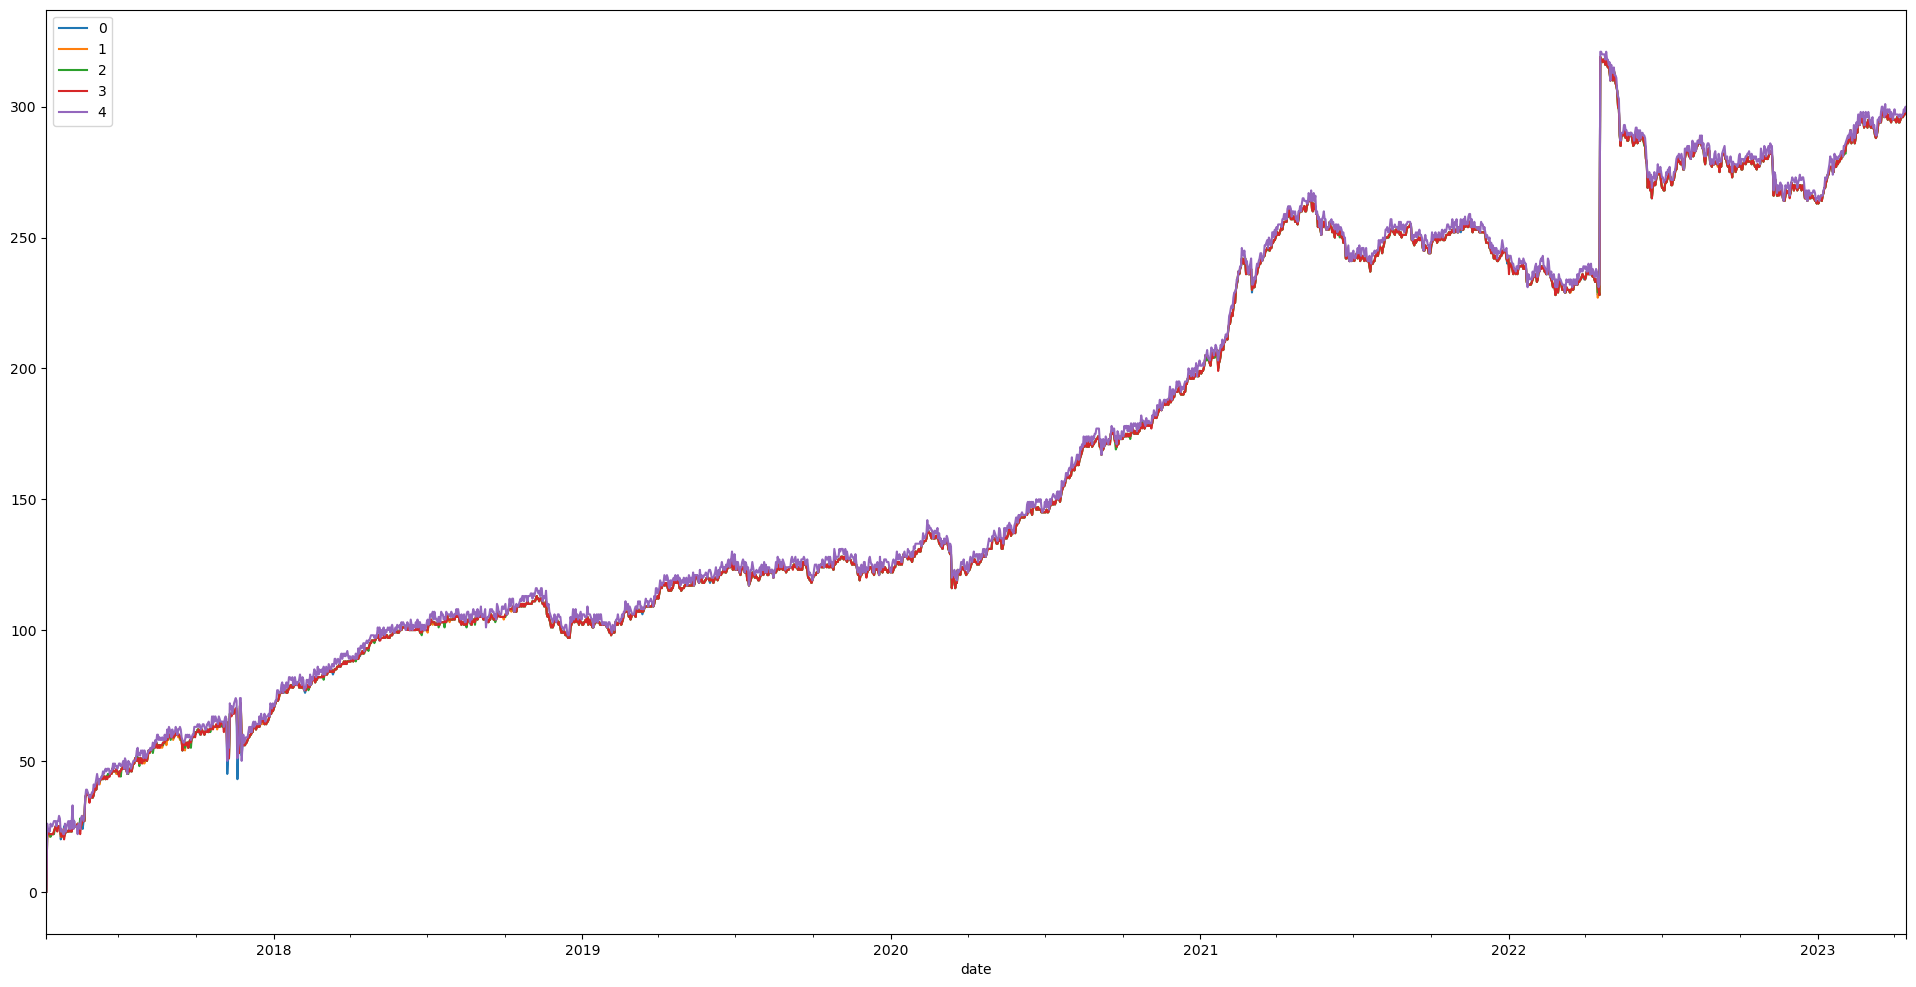

In [13]:
concat2.plot(figsize=(24,12));

In [14]:
rtn_dict = {"Q1":rtn_g1.sum(1),
            "Q2":rtn_g2.sum(1),
            "Q3":rtn_g3.sum(1),
            "Q4":rtn_g4.sum(1),
            "Q5":rtn_g5.sum(1)}

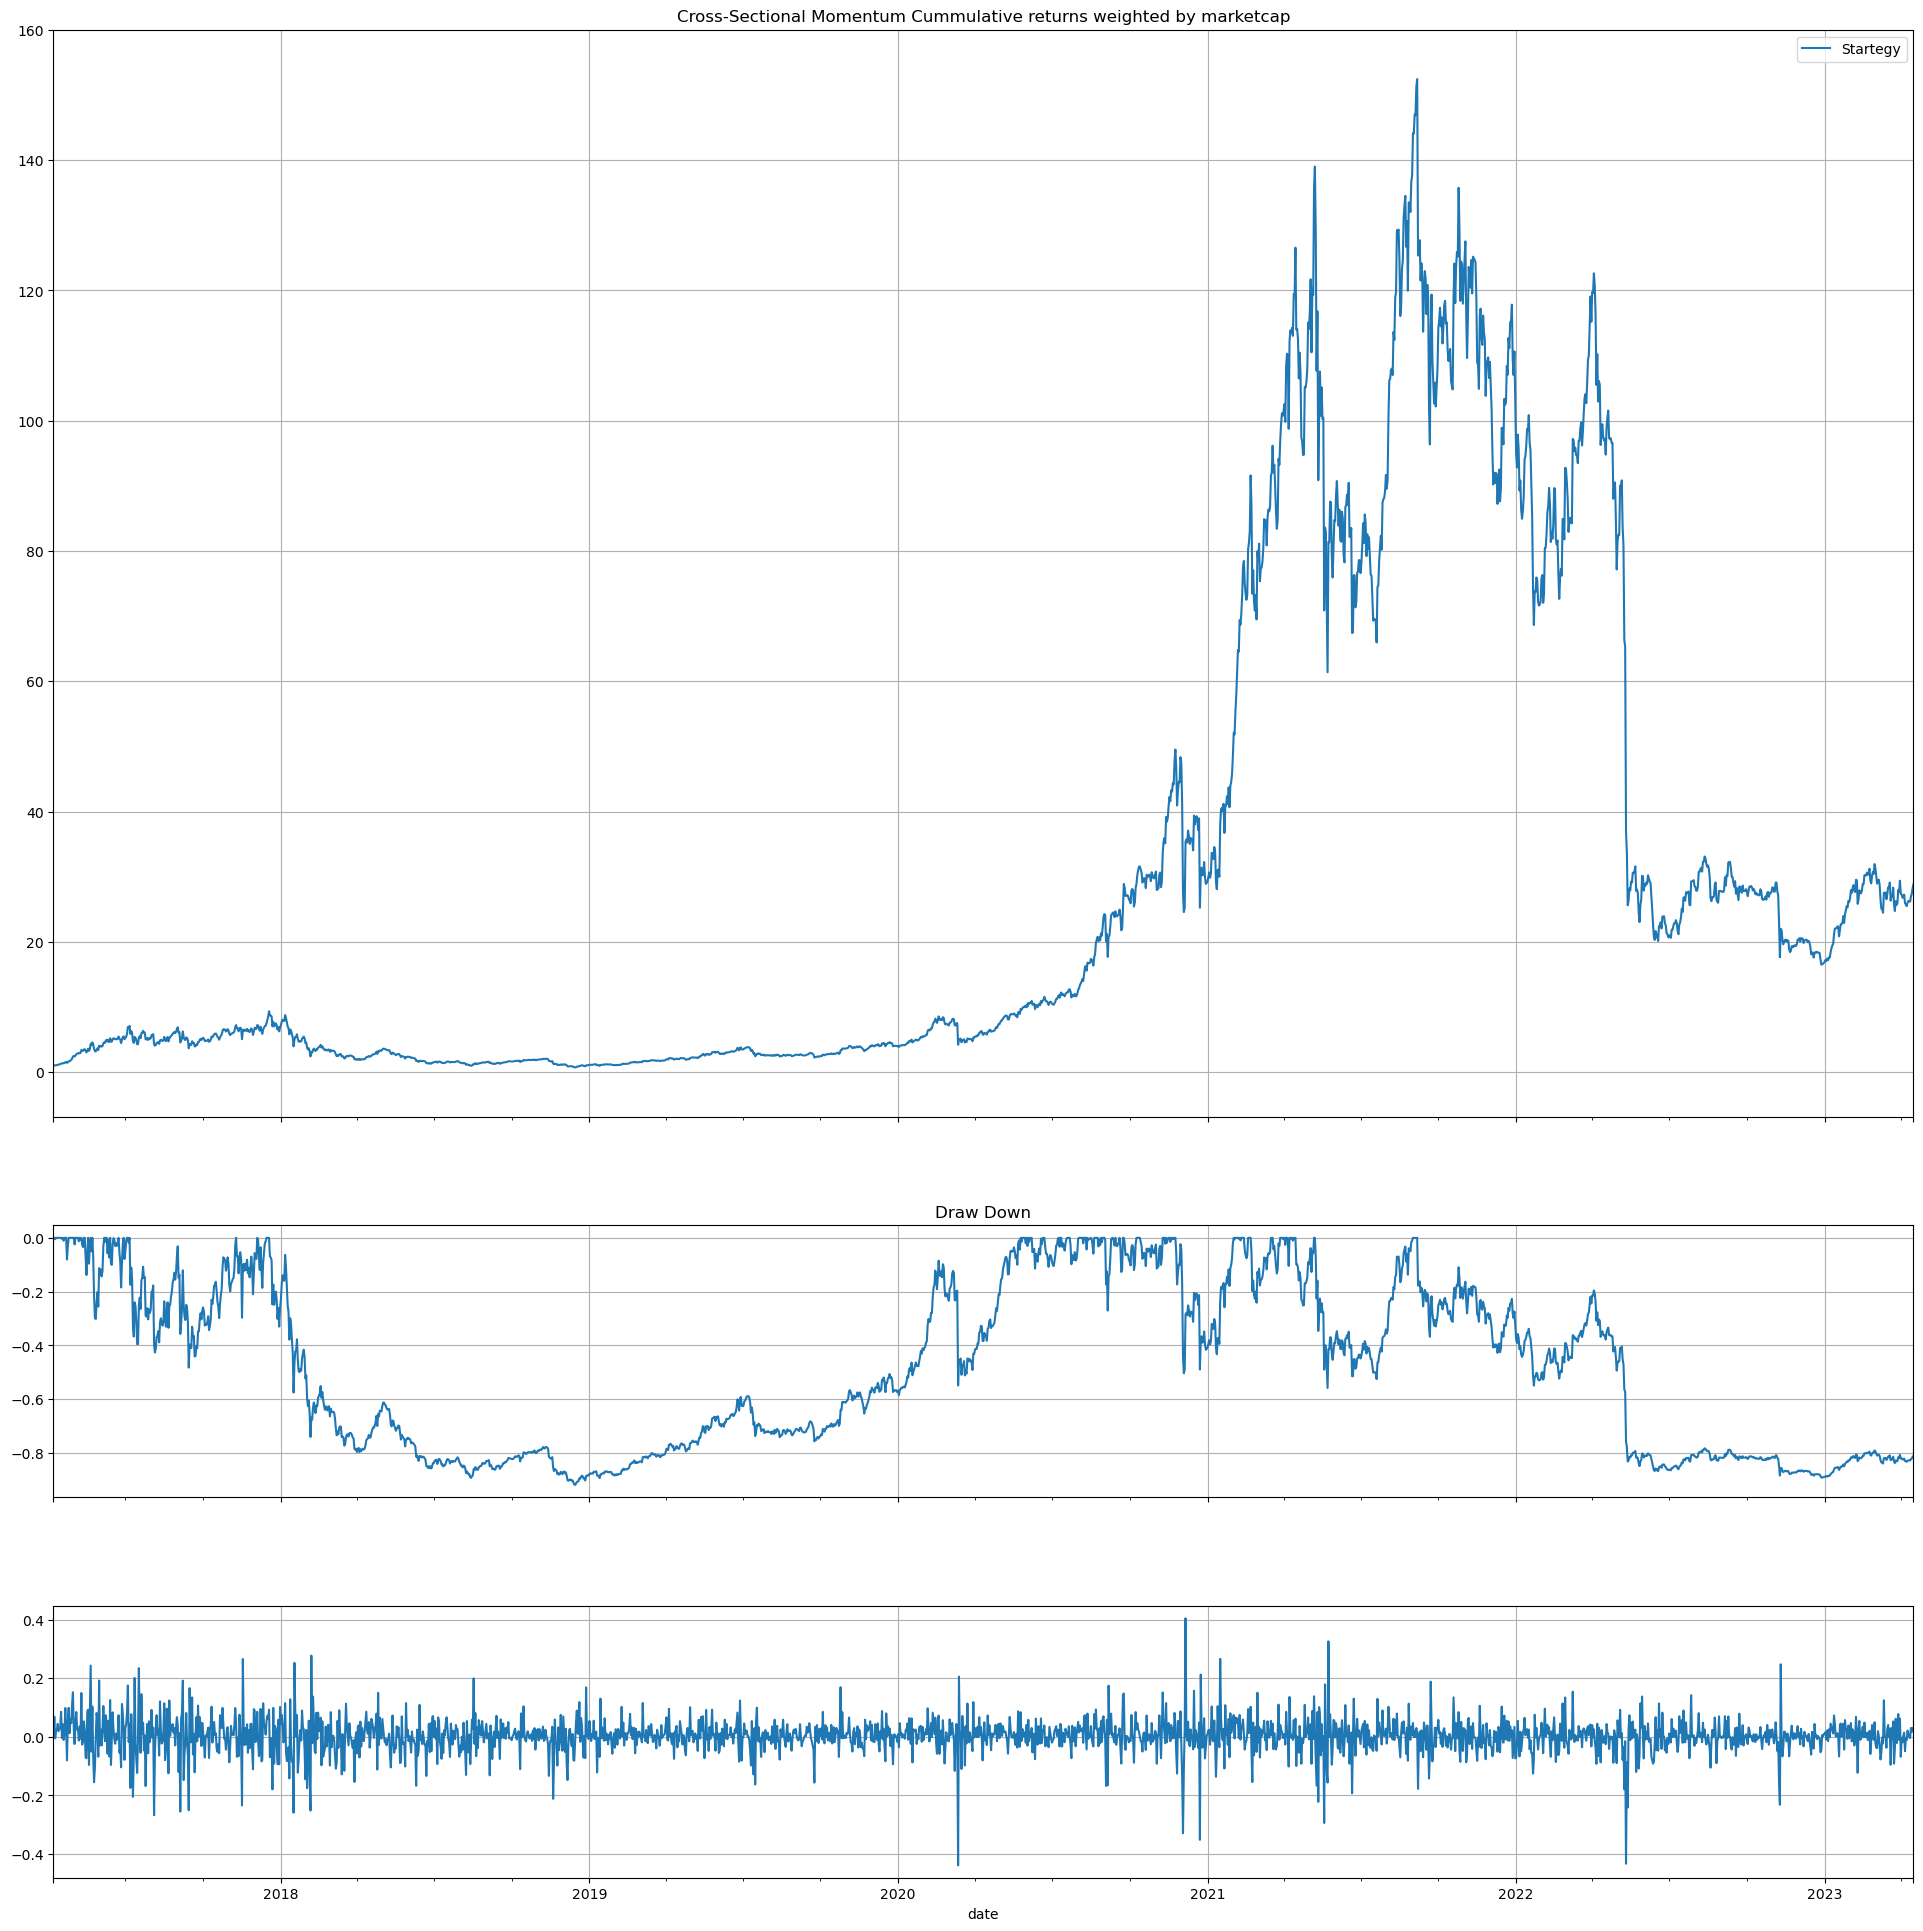

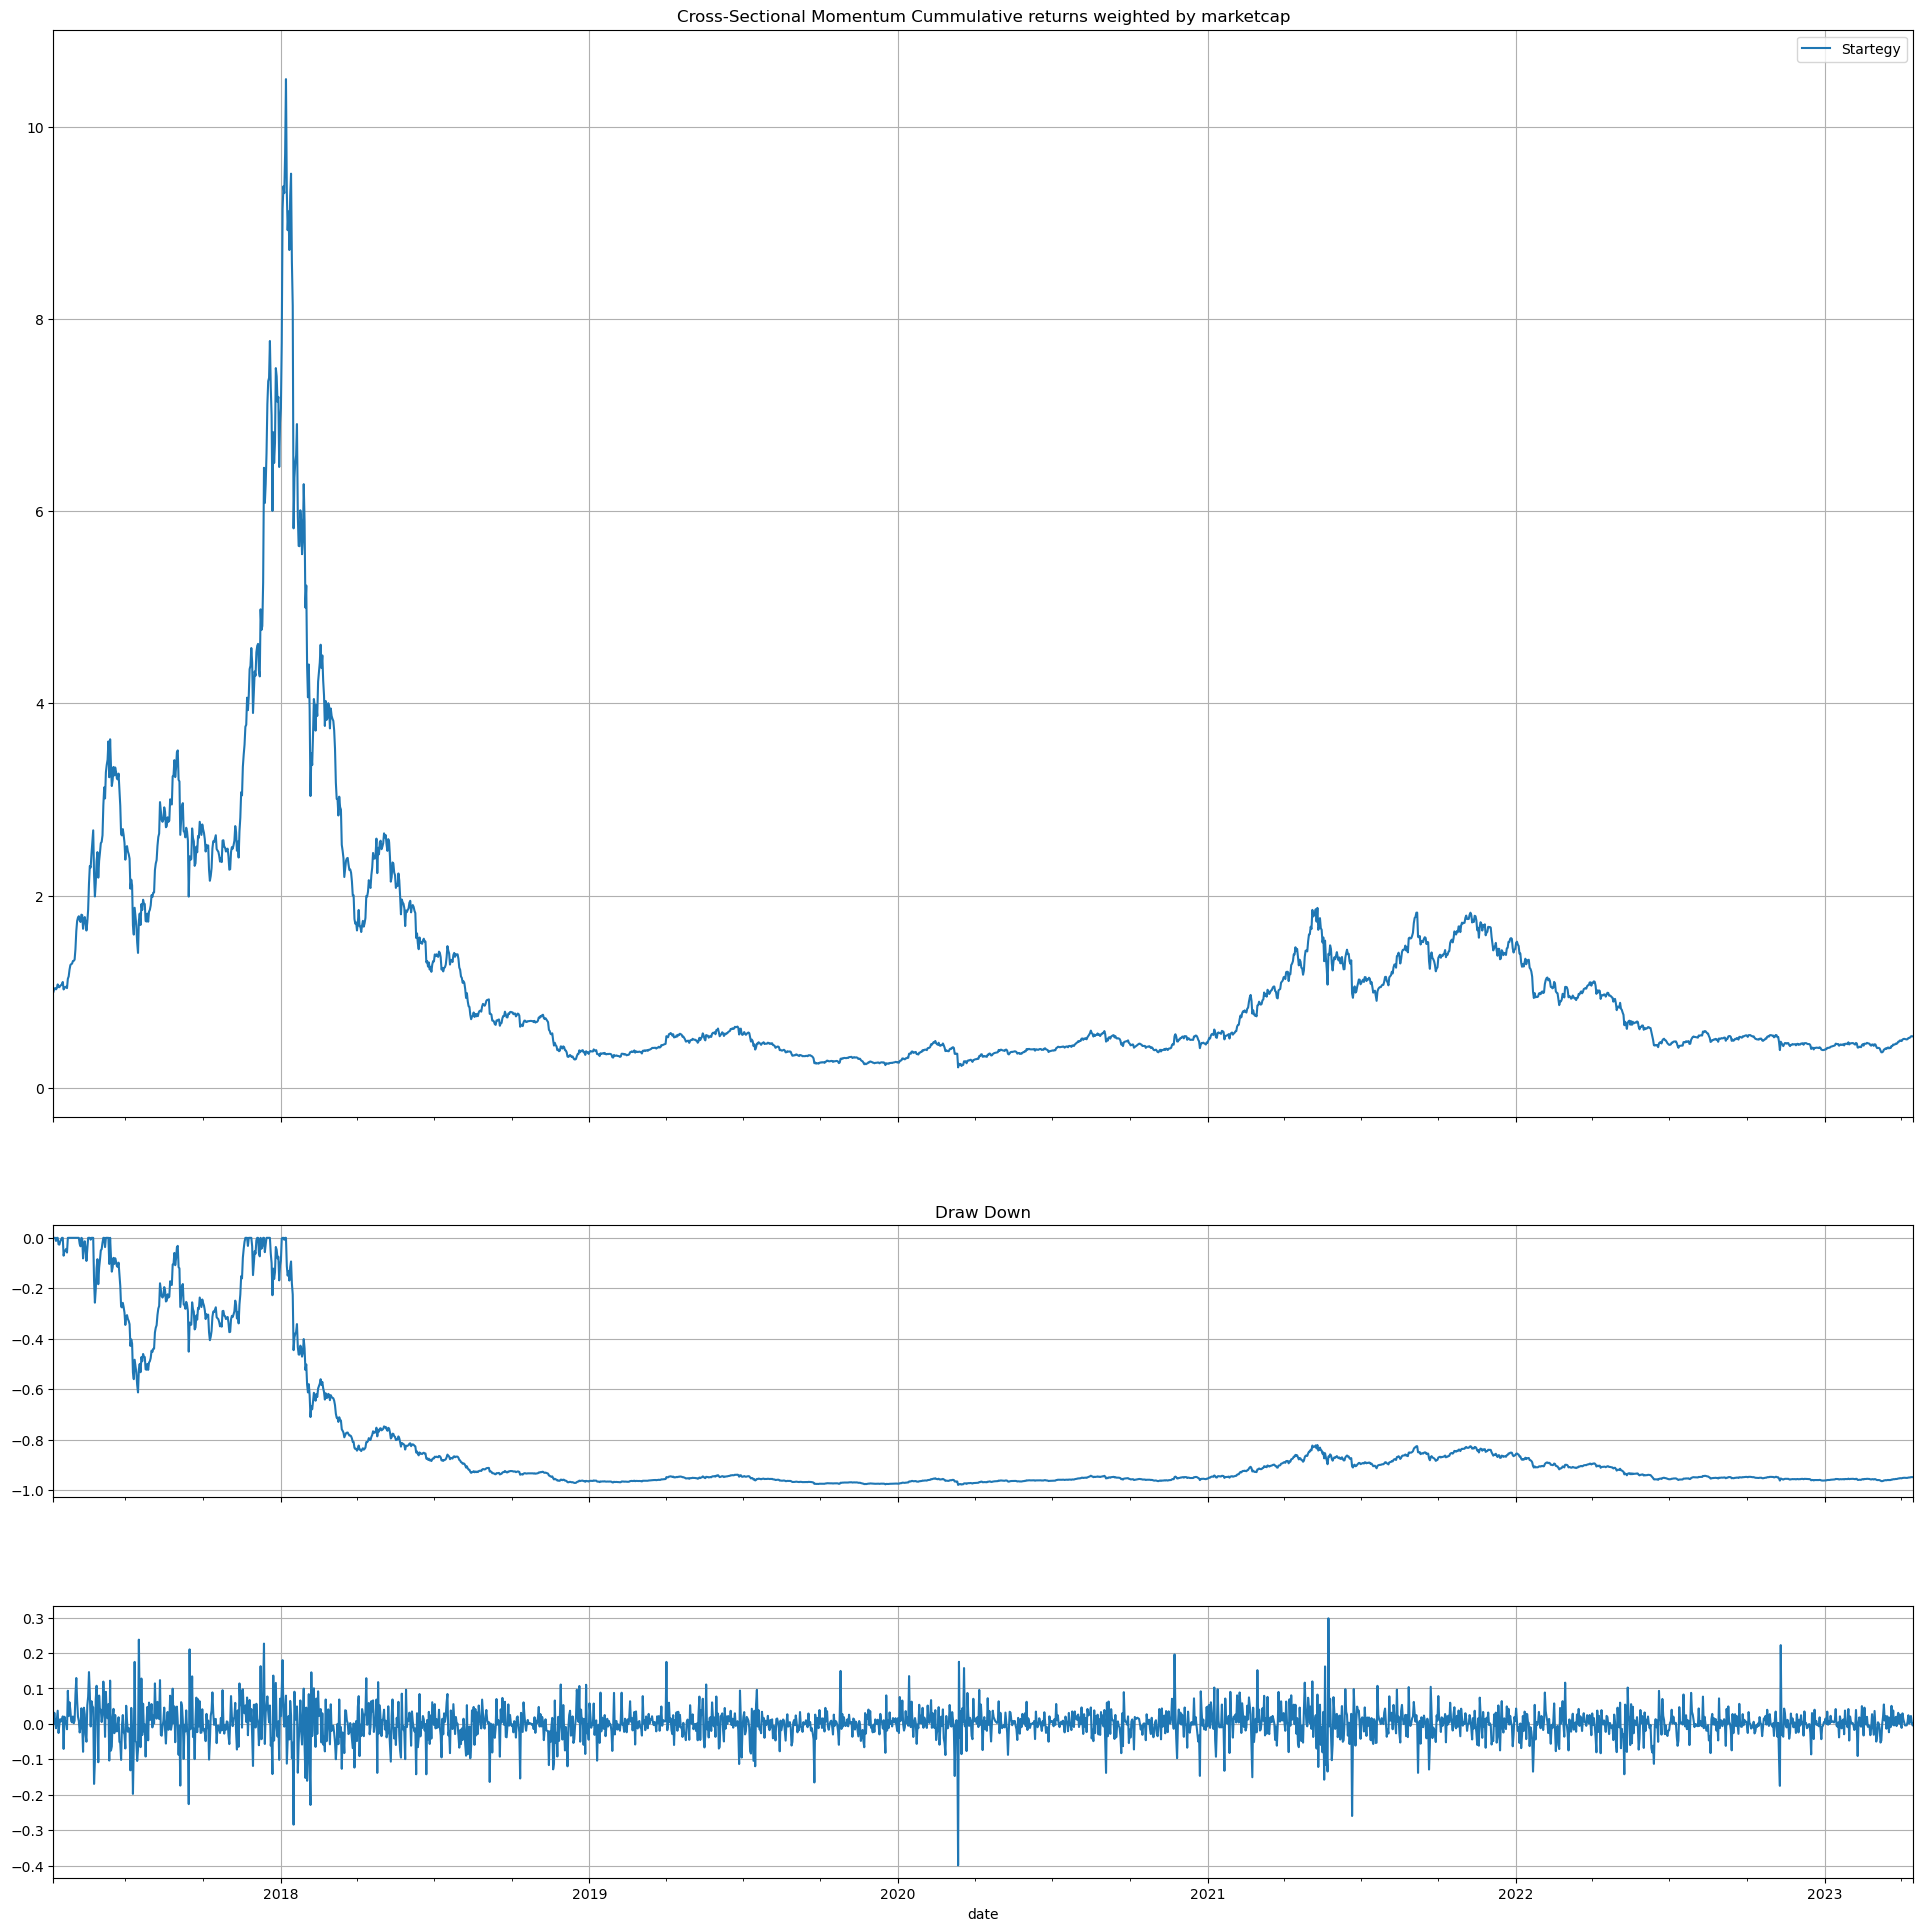

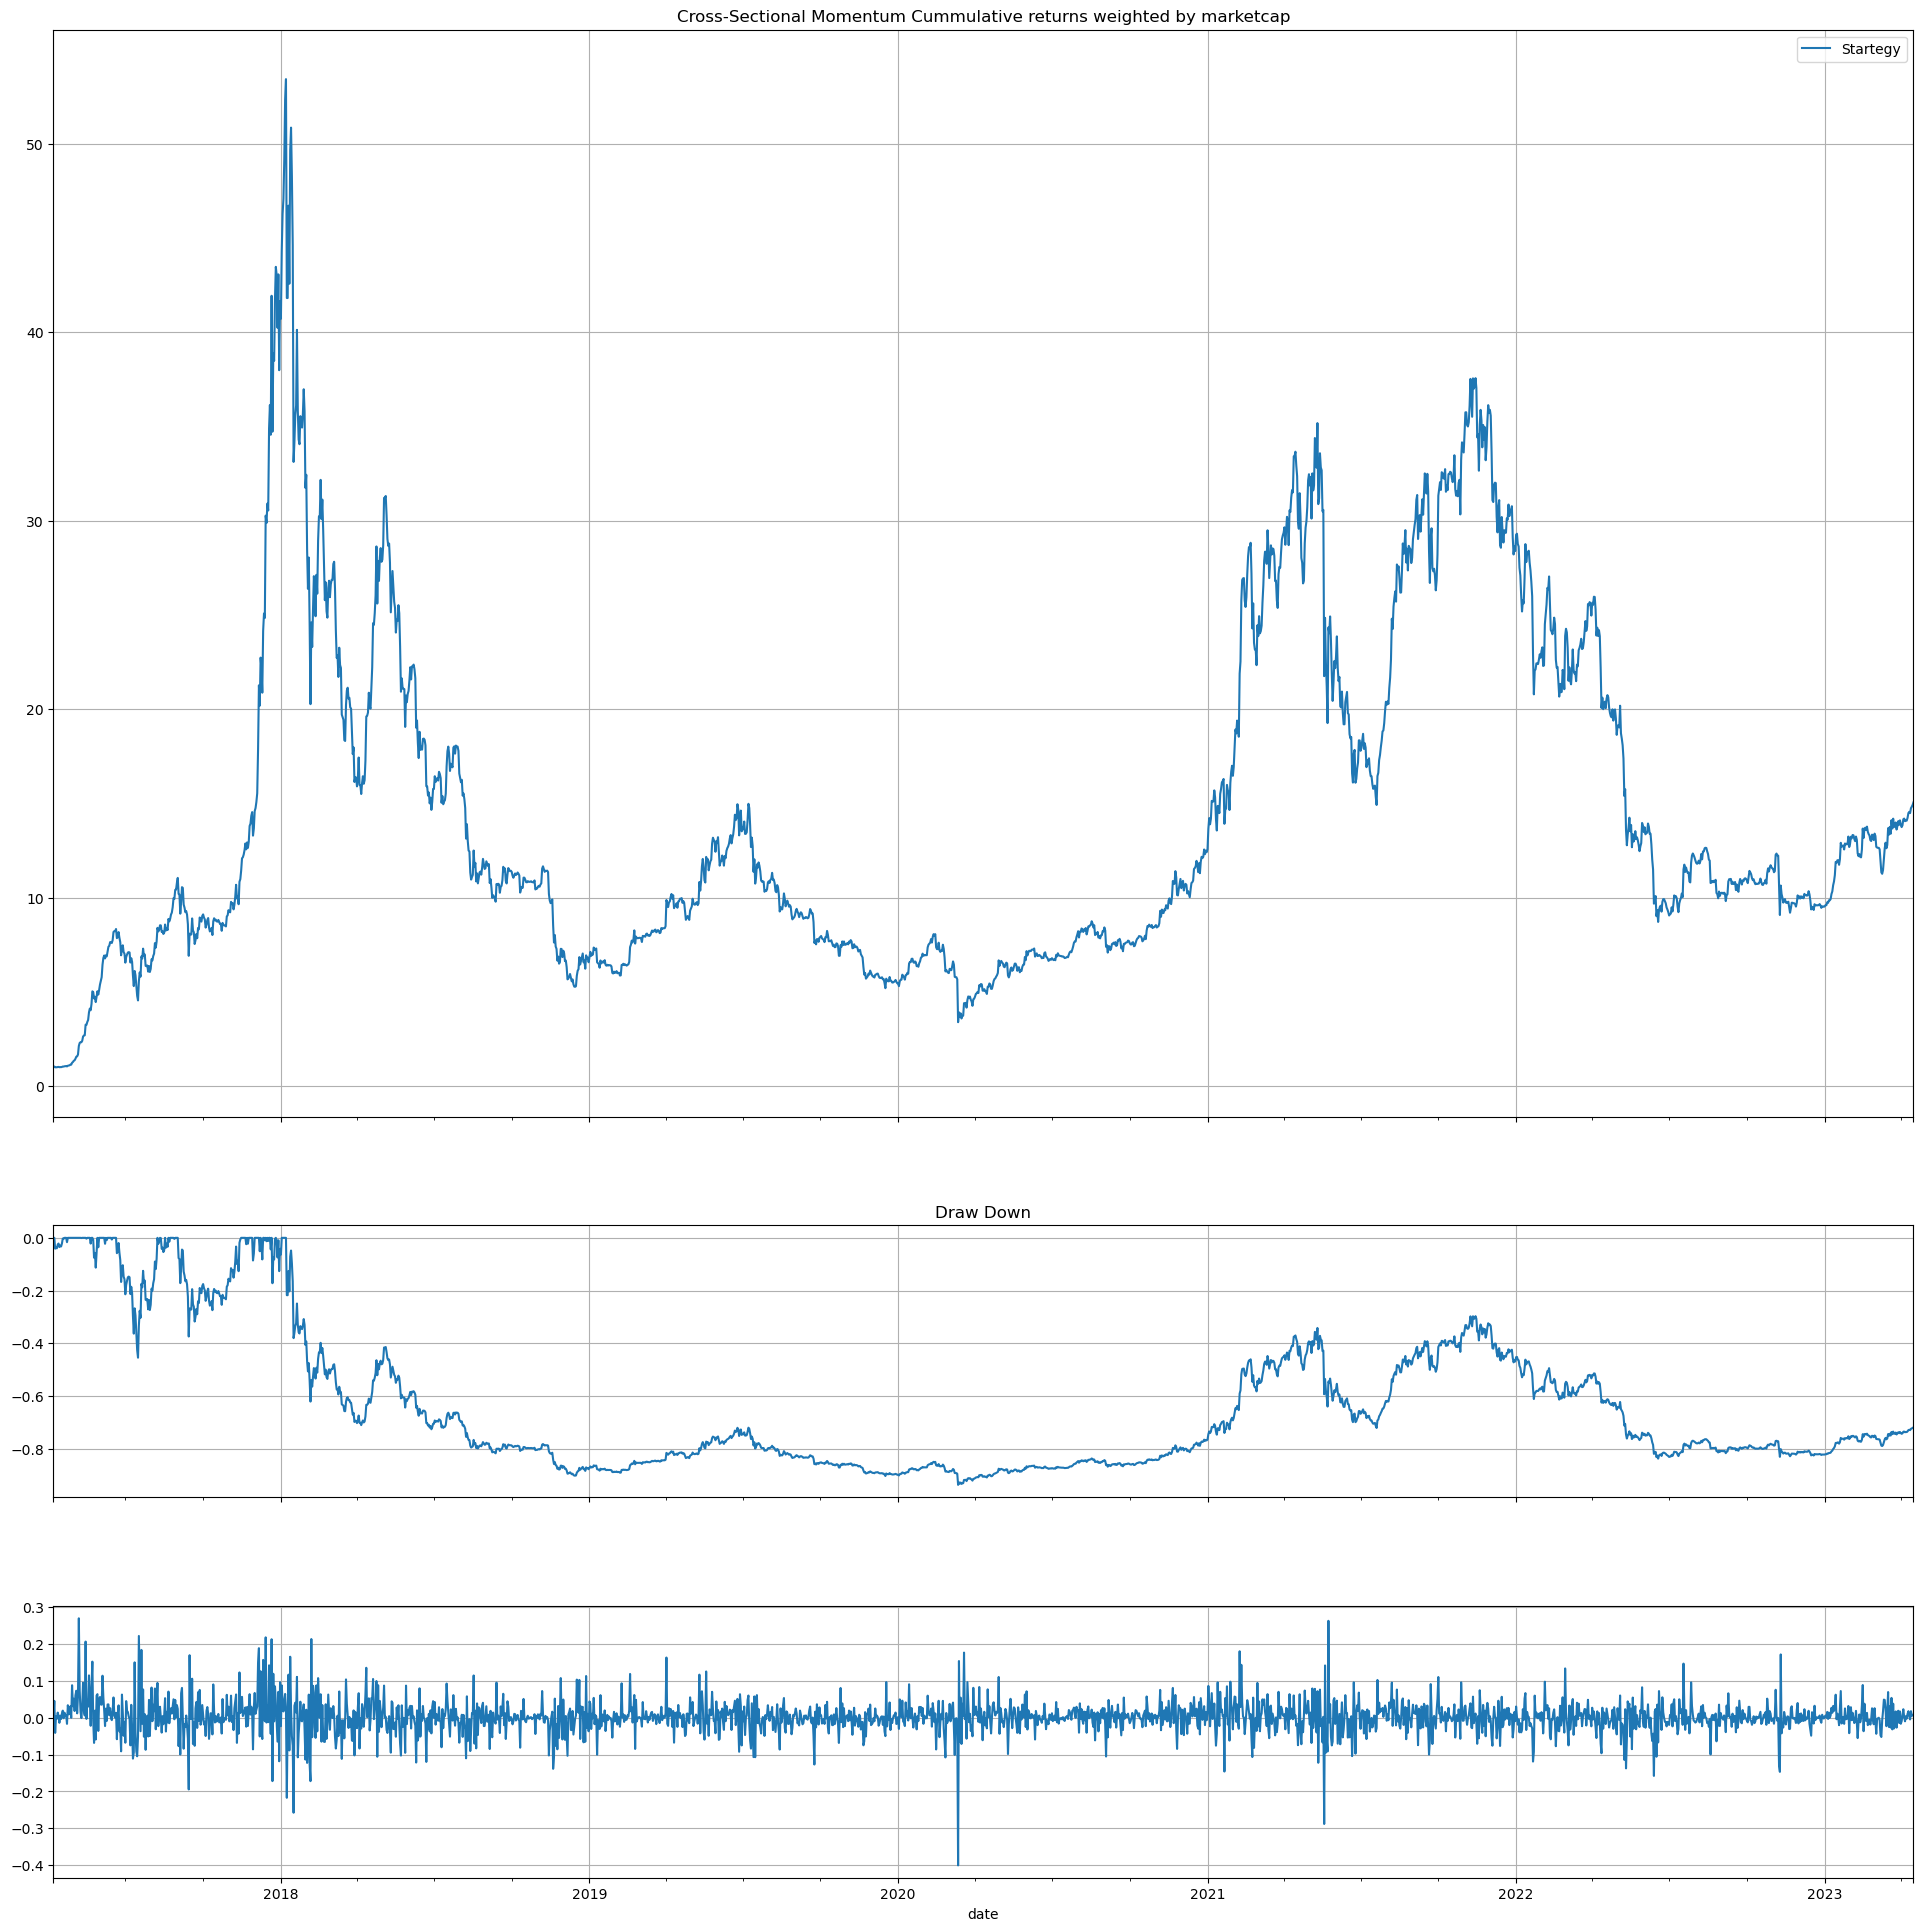

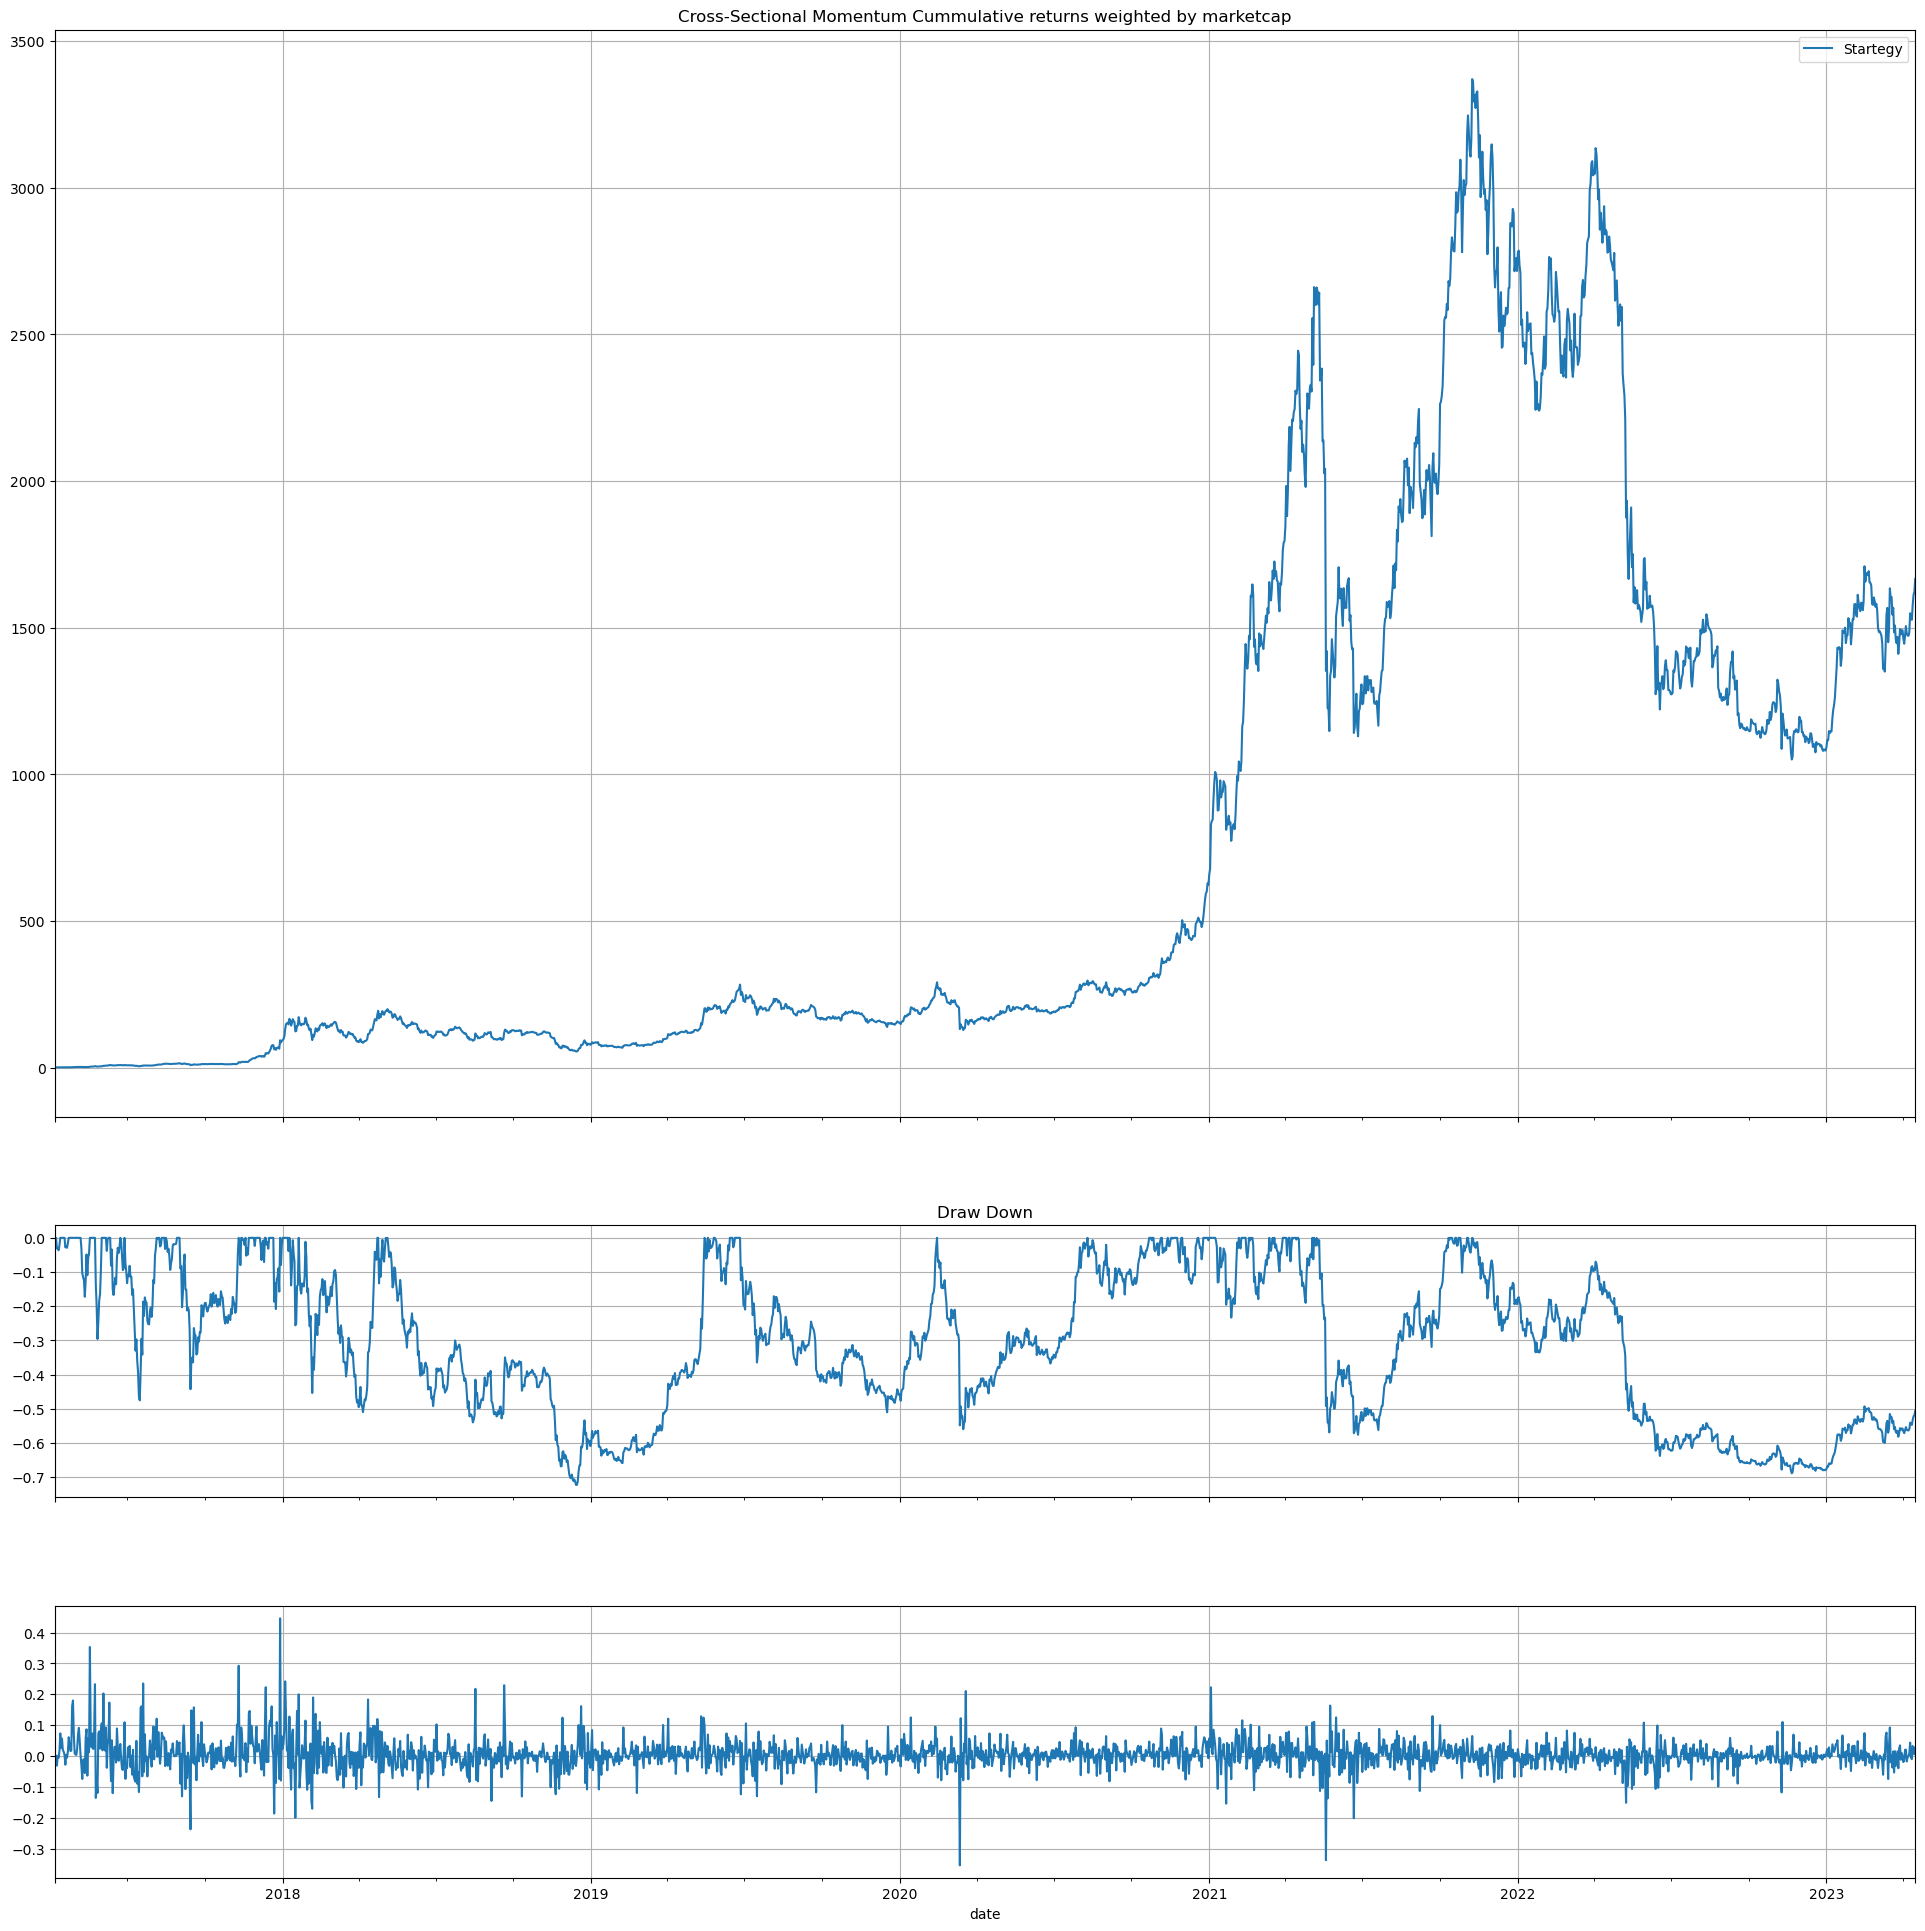

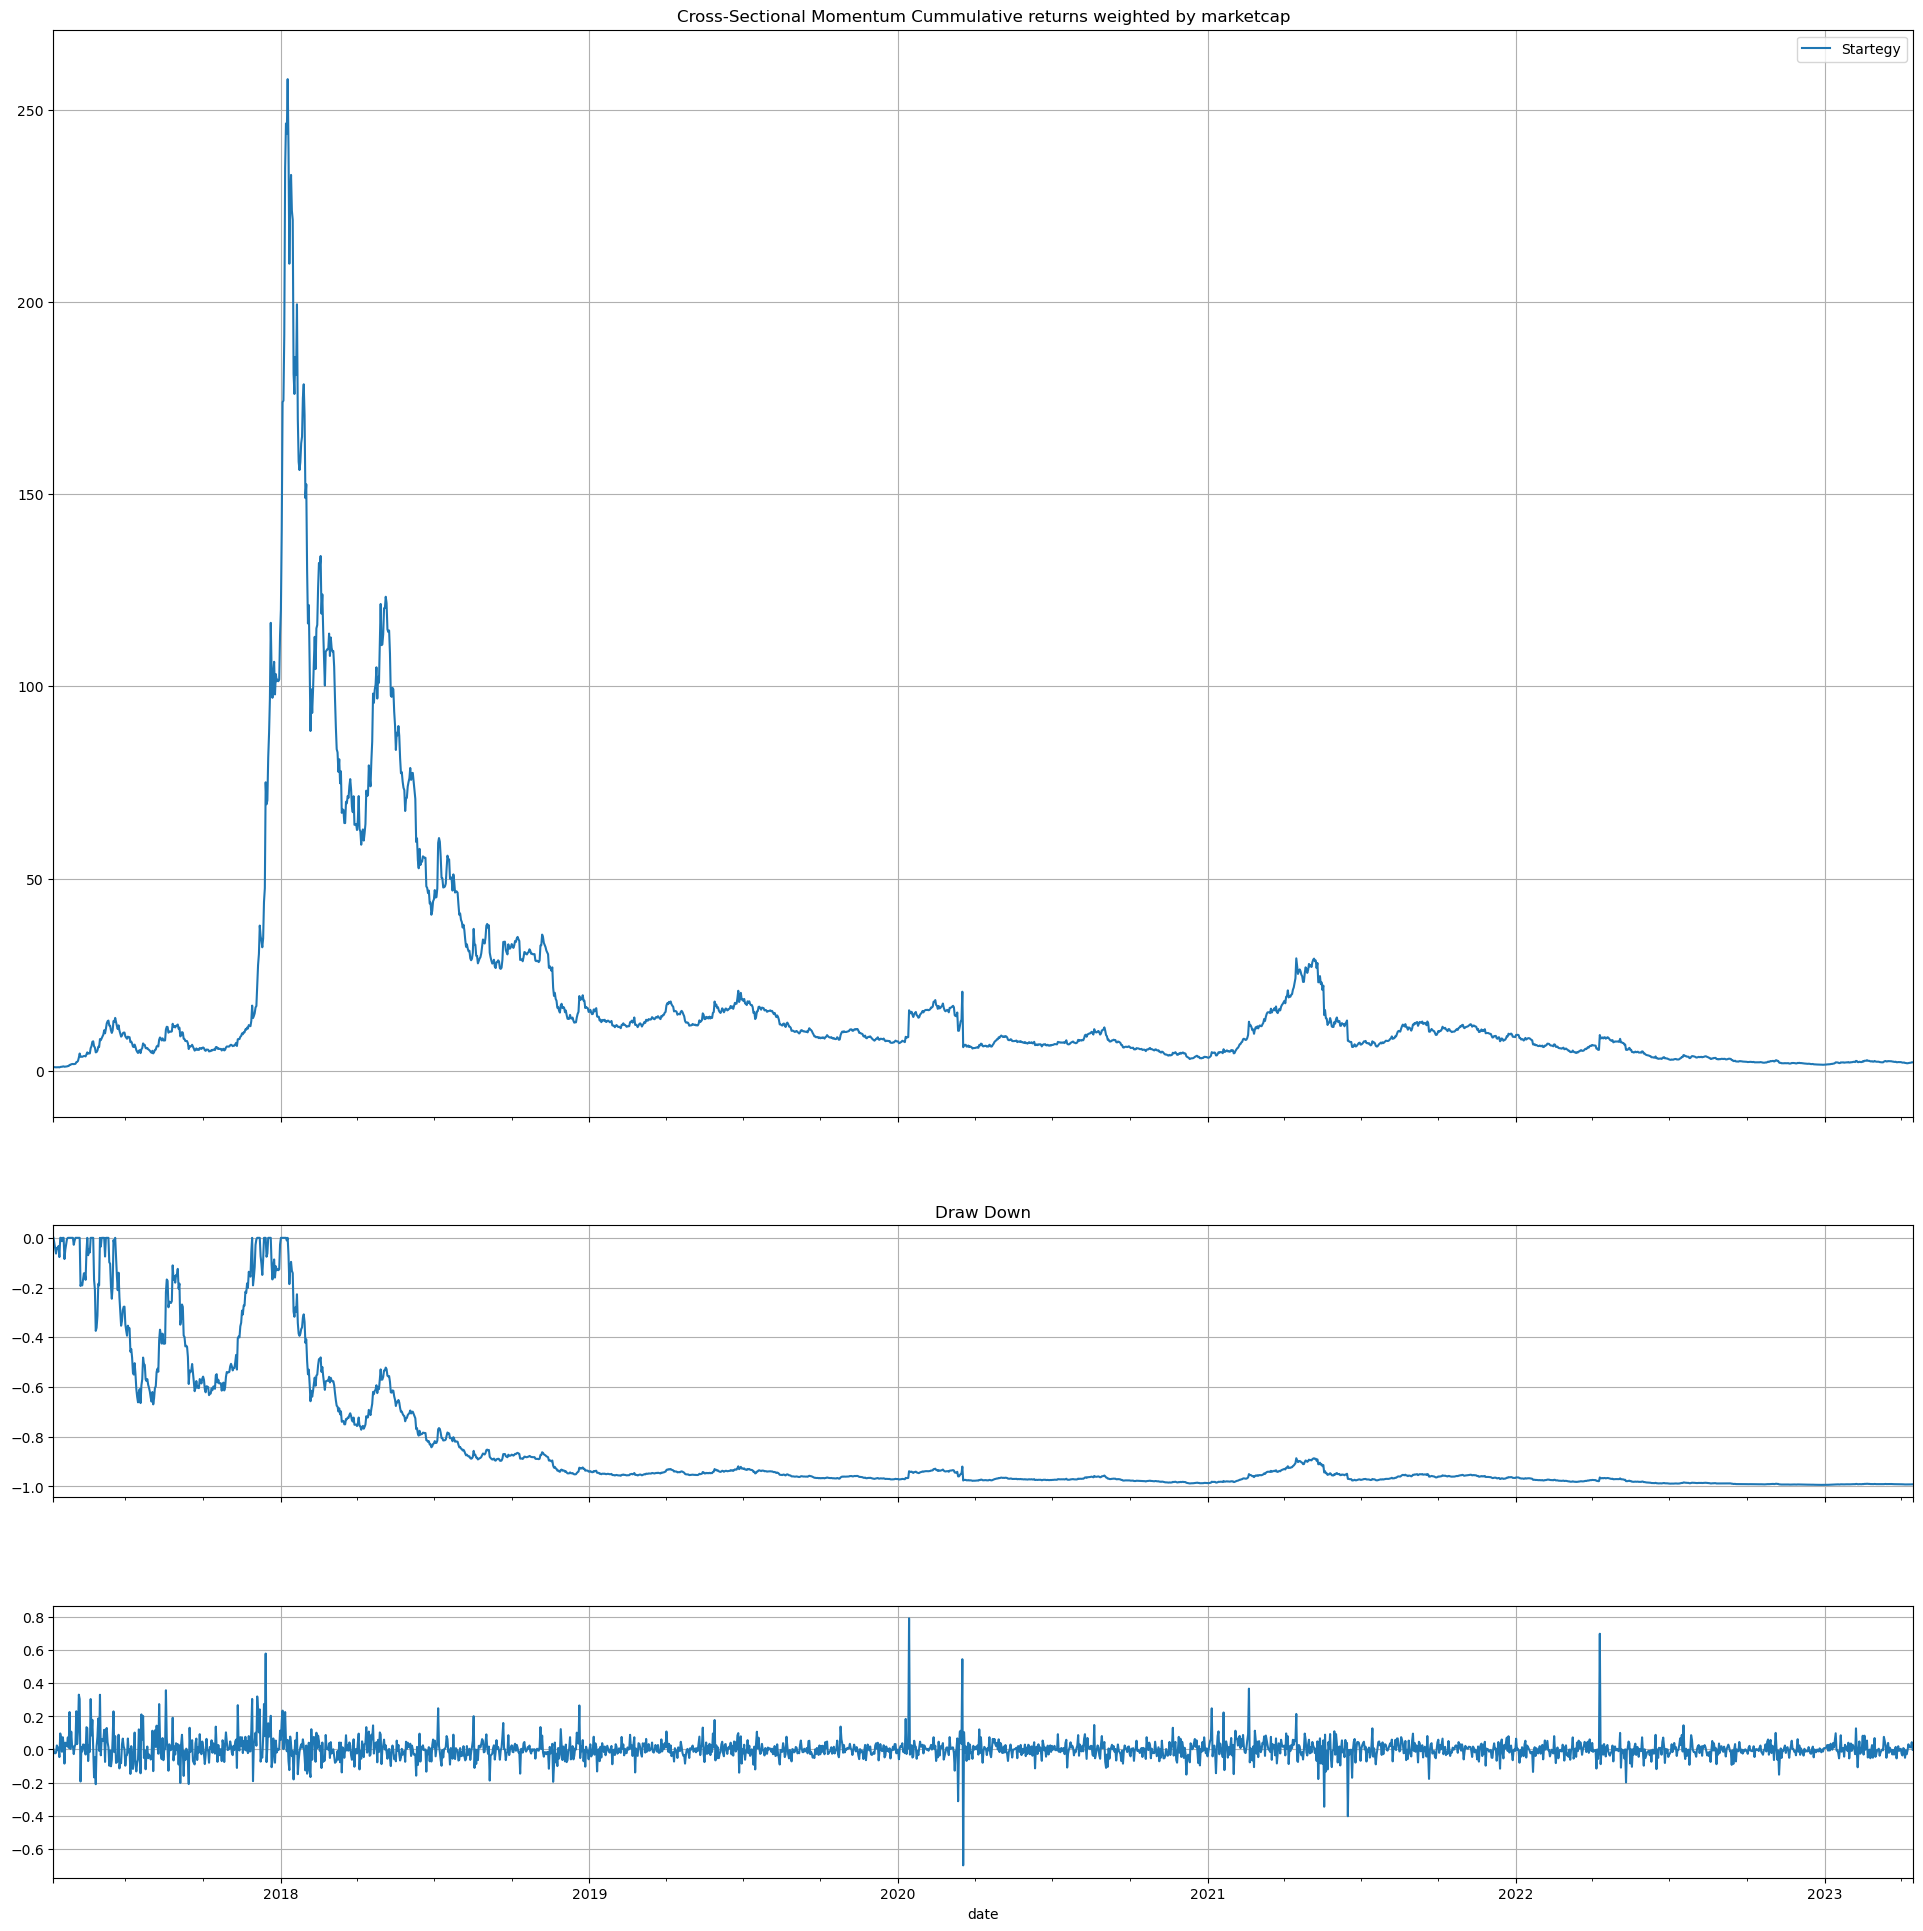

In [15]:
mytool.draw_return_result(rtn_dict, with_mkt=False)

In [16]:
mytool.print_statistics(rtn_dict, False)

TypeError: object of type 'bool' has no len()